In [1]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [17]:
# Importing data: 
    #y - Price
    #x - area
    #z1 - neighborhood_quality
    #z2 - # of bedrooms
df = pd.read_csv("https://raw.githubusercontent.com/torokpe/DA4/refs/heads/main/house_prices.csv")[["House_Price", "Square_Footage","Neighborhood_Quality","Num_Bedrooms"]]

<Axes: >

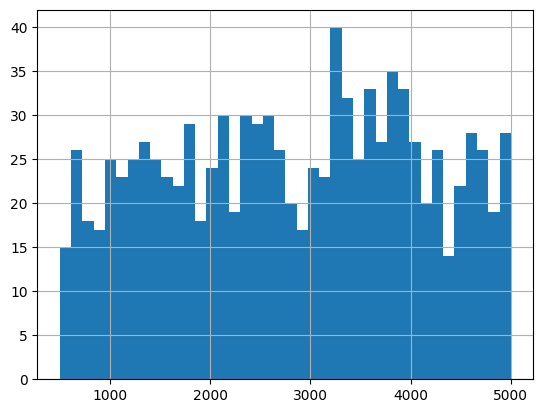

In [18]:
df['Square_Footage'].hist(bins=40)

<Axes: >

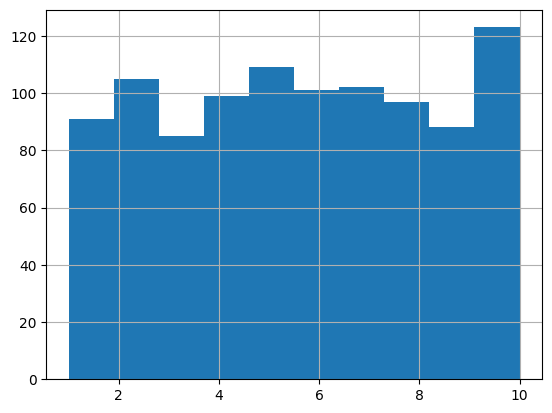

In [19]:
df['Neighborhood_Quality'].hist(bins=10)

Original dataset size: (1000, 4)
Filtered dataset size (after simulating lack of common support): (779, 4)
                            OLS Regression Results                            
Dep. Variable:            House_Price   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 2.331e+04
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:40:52   Log-Likelihood:                -11729.
No. Observations:                1000   AIC:                         2.347e+04
Df Residuals:                     996   BIC:                         2.349e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------

/var/folders/2t/xkvs6xd56jd85tg6jv1m01gh0000gn/T/ipykernel_21458/3273446561.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['z1_rounded'] = df_filtered['Neighborhood_Quality'].round(1)
/var/folders/2t/xkvs6xd56jd85tg6jv1m01gh0000gn/T/ipykernel_21458/3273446561.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['z2_rounded'] = df_filtered['Num_Bedrooms'].round(1)
/var/folders/2t/xkvs6xd56jd85tg6jv1m01gh0000gn/T/ipykernel_21458/3273446561.py:25: SettingWithCopyWarning: 
A value 

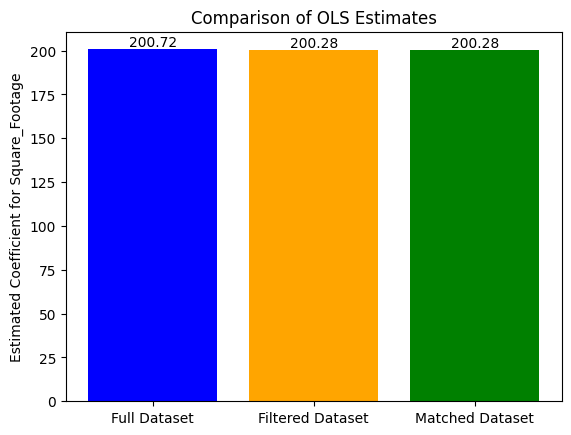

In [20]:
# Step 1: Simulate Lack of Common Support
# Remove rows where Neighborhood_Quality is high but Square_Footage is low
df_filtered = df[(df['Square_Footage'] > 2000) | (df['Neighborhood_Quality'] < 4)]

print(f"Original dataset size: {df.shape}")
print(f"Filtered dataset size (after simulating lack of common support): {df_filtered.shape}")

# Step 2: Perform OLS on the Full Dataset
X_full = sm.add_constant(df[['Square_Footage', 'Neighborhood_Quality', 'Num_Bedrooms']])
ols_full = sm.OLS(df['House_Price'], X_full).fit()

print(ols_full.summary())

# Step 3: Perform OLS on the Filtered Dataset
X_filtered = sm.add_constant(df_filtered[['Square_Footage', 'Neighborhood_Quality', 'Num_Bedrooms']])
ols_filtered = sm.OLS(df_filtered['House_Price'], X_filtered).fit()

print("\nOLS Results (Filtered Dataset):")
print(ols_filtered.summary())

# Step 4: Exact Matching on Filtered Dataset
# Round z1 and z2 for matching
df_filtered['z1_rounded'] = df_filtered['Neighborhood_Quality'].round(1)
df_filtered['z2_rounded'] = df_filtered['Num_Bedrooms'].round(1)
df_filtered['match_key'] = df_filtered['z1_rounded'].astype(str) + '_' + df_filtered['z2_rounded'].astype(str)

# Separate treated and control groups (based on Square_Footage median)
median_sf = df_filtered['Square_Footage'].median()
treated = df_filtered[df_filtered['Square_Footage'] > median_sf]
control = df_filtered[df_filtered['Square_Footage'] <= median_sf]

# Find matches based on match_key
matched_control = control[control['match_key'].isin(treated['match_key'])]
matched_treated = treated[treated['match_key'].isin(control['match_key'])]
matched_data = pd.concat([matched_treated, matched_control])

# Step 5: Perform OLS on Matched Dataset
X_matched = sm.add_constant(matched_data[['Square_Footage', 'Neighborhood_Quality', 'Num_Bedrooms']])
ols_matched = sm.OLS(matched_data['House_Price'], X_matched).fit()

print("\nOLS Results (Matched Dataset):")
print(ols_matched.summary())

# Step 6: Compare Results
print("\nComparison of Coefficients for Square_Footage:")
print(f"Full Dataset: {ols_full.params['Square_Footage']:.4f}")
print(f"Filtered Dataset: {ols_filtered.params['Square_Footage']:.4f}")
print(f"Matched Dataset: {ols_matched.params['Square_Footage']:.4f}")

# Step 7: Visualize the Bias
coefficients = [
    ols_full.params['Square_Footage'],
    ols_filtered.params['Square_Footage'],
    ols_matched.params['Square_Footage']
]
labels = ['Full Dataset', 'Filtered Dataset', 'Matched Dataset']

plt.bar(labels, coefficients, color=['#5ab4ac', '#d8b365', '#d8b365'])

# Add labels at the top of each bar
for i, value in enumerate(coefficients):
    plt.text(i, value + 0.05, f'{value:.2f}', ha='center', va='bottom')

# Add axis labels and title
plt.ylabel('Coefficient')
plt.title('Comparison of OLS Estimates')

# Display the plot
plt.show()